In [6]:
from skimage.morphology import skeletonize, thin, binary_erosion
from skimage import data
import matplotlib.pyplot as plt
from skimage.util import invert
import imageio
from scipy import misc
from skimage import color
from skimage import measure
import sys

#Set up workspace
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import imageio
import pylab as plx

np.set_printoptions(threshold=sys.maxsize, linewidth=1000)

In [87]:
"""
Tommy's Utility Functions for converting images from color to black and white.
"""

def make_bw(img,thresh=130):
    # Converts from color to bw/binary image
    gray = lambda rgb : np.dot(rgb[... , :3] , [0.299 , 0.587, 0.114]) 
    gray_img = gray(img)
    bw_img = bw_convert(gray_img,thresh)
    
    return bw_img

def bw_convert(img,thresh):
    # Converts the grayscale to a simple black-white: that may help us in observing the 
    # "Fractal" structure (and other formal qualities)
    bw_pic = img.copy()
    bw_mask = bw_pic[:, :,] < thresh
    bw_pic[bw_mask] = 0
    bw_pic[~bw_mask] = 1
    return bw_pic


(335, 332, 3)
[ True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True False  True  True  True  True  True  True  True  True  

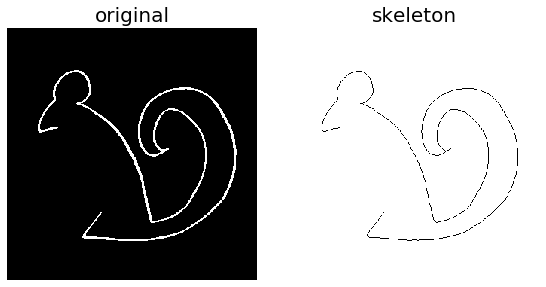

In [11]:
# Invert the squirrel image
squirrel = imageio.imread('images/squirrel.jpg') 
print(squirrel.shape)
squirrel_bw = invert(make_bw(squirrel))
skeleton = invert(thin(squirrel_bw))

# display results
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4),
                         sharex=True, sharey=True)

ax = axes.ravel()

ax[0].imshow(squirrel_bw, cmap=plt.cm.gray)
ax[0].axis('off')
ax[0].set_title('original', fontsize=20)

ax[1].imshow(skeleton, cmap=plt.cm.gray)
ax[1].axis('off')
ax[1].set_title('skeleton', fontsize=20)
print(skeleton[150])

fig.tight_layout()
plt.show()

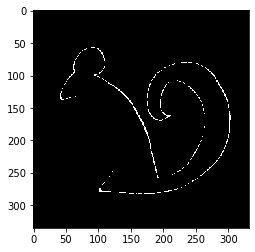

In [88]:
inverted_image = invert(make_bw(squirrel))
eroded_image = binary_erosion(inverted_image)

plt.imshow(eroded_image, cmap=plt.cm.gray)

Neither erosion or skeleton produces a nice continuous set of points; we'll have to go another route. We ultimately landed on using contours, and grabbing the "correct" 50% constituting one line.

This is a fairly manual process that mostly comprised of "guessing and checking", and in future iterations, we'd like to find a more elegant / automated solution to this.

(1, 3177, 2)


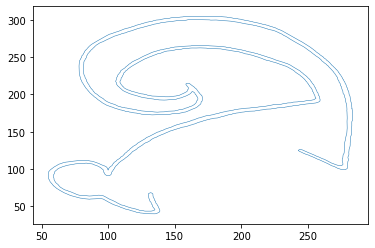

In [92]:
initial_image = imageio.imread("images/squirrel.jpg")
gray_scale_image = color.colorconv.rgb2grey(initial_image)
contours = measure.find_contours(gray_scale_image, 0.8)
# Now cast it to an NP array so it's more workable.
contours = np.array(contours)
print(contours.shape)

contour = contours[0]
xs = contour[:, 0]
ys = contour[:, 1]
plt.plot(xs, ys,  linewidth=0.5)
plt.show()

# Now, perform some matrix transformations on 
# the resulting contour to get the image into the form as desired.
def rotate_points(coordinate_pair):
    rotation_matrix = np.array([
        [0, 1],
        [-1, 0]
    ])
    result = np.matmul(rotation_matrix, coordinate_pair)
    return result

def translate_y(coordinate_pair):
    # TODO: these numbers are super hard-coded --- there's probably a simple way to make
    # this more programmatic by picking the most negative Y if there are negatives and translating it
    # And if all Y's are positive, bring them down
    result = [coordinate_pair[0], coordinate_pair[1] + 300]
    return result

# Do a reverse 90-degree matrix transformation on the points to rotate the image
contours = np.array([[rotate_points(cp) for cp in contours[0]]])
# And now move the points upwards by adding 300 to each point 
contours = np.array([[translate_y(cp) for cp in contours[0]]])

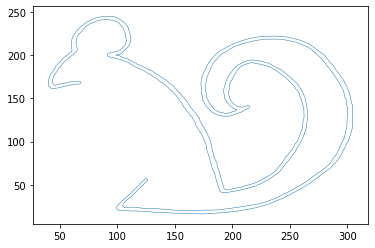

In [93]:
# Image once after the above matrix transformations have been applied:
contour = contours[0]
xs = contour[:, 0]
ys = contour[:, 1]
plt.plot(xs, ys,  linewidth=0.5)

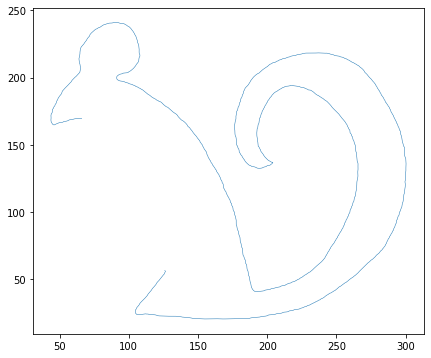

In [94]:
# Now, we must find the approximate 50% of the image to generate just one line; 
# since the vector starts and ends at the same point. This is a deeply manual process, 
# and if we had the extra time, perhaps we could find a way to automate this.
row_start = 1465
row_end = 3025

# Now, we can plot the image
# TODO: Get a figure at the normal size
plt.figure(figsize=(7, 6))

contour = contours[0]
xs = contour[row_start:row_end, 0]
ys = contour[row_start:row_end, 1]
plt.plot(xs, ys,  linewidth=0.5)


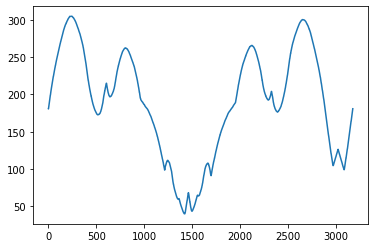

In [95]:
# To confirm that this is a continuous line that the vector gave us
plt.plot(contours[0, :, 0])
plt.show()

Text(0.5, 1.0, 'Squirrel, separated into line segments for interpolation')

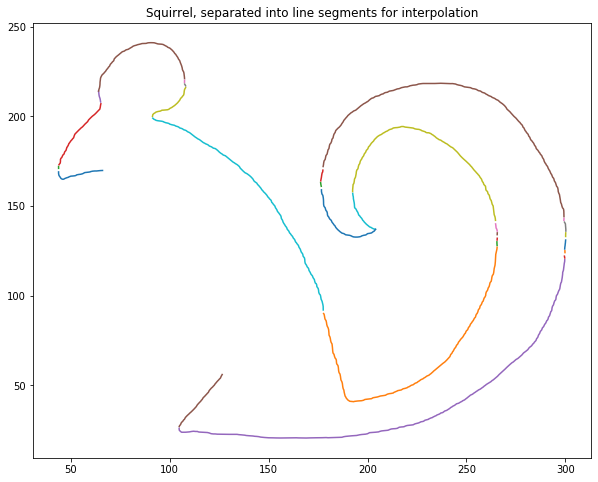

In [98]:
# Process so far: Use vectorization, grab roughly 50% of the line, since there's a start and end point
# Now that we have the continuous line traced, we'll run it through an algorithm to sectionize the line
line_contour = contours[0][row_start:row_end]

def extract_line_segments(line):
    """
    Extracts the line segments for vectorized contour lines such that there 
    are no overlapping Xs. Each of these line segments will be used for
    interpolating a spline. 
    
    Works by detecting the direction of the X, and every time it changes,
    it takes all data points starting at the last segment up until the current index
    to create a new segment, and then starts a new segment pair. 
    A positive direction is marked as True, whereas a decreasing X 
    is indicated as False.
    """
    all_segments = []

    for index, coordinate in enumerate(line):
        x, y = coordinate
        if index == 0:
            """
            Stick the initial two points into the segment array
            and get the first "prev_direction" (which will be the same 
            as the next on the initial run) to start the process.
            """
            segment_start = 0
            prev_direction = (x - line[1][0]) < 0
            previous_x = x
            continue
        direction = (x - previous_x) > 0

        if direction != prev_direction:
            all_segments.append(line[segment_start:index])
            segment_start = index
        previous_x = x
        prev_direction = direction
    return np.array(all_segments)

line_segments = extract_line_segments(line_contour)

plt.figure(figsize=(10, 8))
for line_segment in line_segments:
    xs = line_segment[:, 0]
    ys = line_segment[:, 1]
    plt.plot(xs, ys)

plt.title("Squirrel, separated into line segments for interpolation")

19


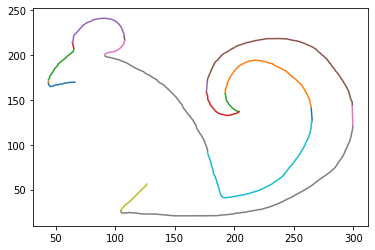

In [166]:
def handle_micro_segments(line_segments, threshold):
    """
    Detects a series of adjacent micro-segments and connects
    them into one larger segment for spline interpolation.
    
    Threshold indicates the number of points that a segment
    must fall under for it to be deemed "too small."
    """
    result = []
    aggregation_mode = False
    for index, segment in enumerate(line_segments):
        size = segment.shape[0]
        if size < threshold:
            if not aggregation_mode:
                aggregation_mode = True
                # Grab the first item of the small segment
                first_small_point = segment[0]
            else:
                # Keep grabbing segments
                continue
        else:
            # This means that we need to start small_segment 
            # over again because we saw a huge chunk
            # Reset the counter
            if aggregation_mode:
                last_small_point = line_segments[index - 1][-1]
                # First small and last small should be points
                segment_of_small_points = np.array([first_small_point, last_small_point])
#                 print(segment_of_small_points.shape)
                result.append(segment_of_small_points)
            aggregation_mode = False
            result.append(segment)
    return np.array(result)
                

#         # this is considered a small shape
#         # Before, I start the small shape run, store the segment prior  to it, and
#         # check the X-value of the last item
#         # That way, if the small segment size is way too small, we can try to connect the last point
#         # with the prior OR next large segment, and throw it away.
#         if size < threshold:
#             # There is always the danger that the X point we start and end with will be the same,
#             # such that a polynomial line cannot be interpolated,
#             # but we accept this risk given the numerical nature of these points 
#             # (the probability is sufficiently low)
            
        

results = handle_micro_segments(line_segments, 10)
# print(results.shape)
for line_segment in results:
    xs = line_segment[:, 0]
    ys = line_segment[:, 1]
    plt.plot(xs, ys)
    
print(len(results))

# TODO: once you have a good base, we can iteratively pick points for spline interpolation, measure the error

Aside from documentation of the tools used (see imports above), here are some resources
I used as reference:

- http://freeconnection.blogspot.com/2013/07/vectorize-image-with-python-scikit-image.html